In [1]:
from IPython.display import HTML
import numpy as np
import gym
import random
import tensorflow as tf
import numpy as np
from collections import deque
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Reshape
from keras.optimizers import Adam
from keras.regularizers import l1
import os
import time
import sys
import utils
import matplotlib as matplotlib
import scipy as scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.optimize import linprog
import copy

Using TensorFlow backend.


In [24]:
# This cell contains all environmental numerical settings for simulations
# for the work "Spatial Deep Learning for Wireless Scheduling",
# available at https://ieeexplore.ieee.org/document/8664604.

class parameters():
    def __init__(self):
        # wireless network settings
        self.n_layouts = 10000
        self.n_links = 50
        self.field_length = 500
        self.shortest_directLink_length = 2
        self.longest_directLink_length = 65
        self.shortest_crossLink_length = 1
        self.bandwidth = 5e6
        self.carrier_f = 2.4e9
        self.tx_height = 1.5
        self.rx_height = 1.5
        self.antenna_gain_decibel = 2.5
        self.tx_power_milli_decibel = 40
        self.tx_power = np.power(10, (self.tx_power_milli_decibel-30)/10)
        self.noise_density_milli_decibel = -169
        self.input_noise_power = np.power(10, ((self.noise_density_milli_decibel-30)/10)) * self.bandwidth
        self.output_noise_power = self.input_noise_power
        self.SNR_gap_dB = 6
        self.SNR_gap = np.power(10, self.SNR_gap_dB/10)
        self.setting_str = "{}_links_{}X{}_{}_{}_length".format(self.n_links, self.field_length, self.field_length, self.shortest_directLink_length, self.longest_directLink_length)
        # 2D occupancy grid setting
        self.cell_length = 5
        self.n_grids = np.round(self.field_length/self.cell_length).astype(int)
        self.INCLUDE_FADING = True
        
        
def layout_generate(general_para):
    N = general_para.n_links
    # first, generate transmitters' coordinates
    tx_xs = np.random.uniform(low=0, high=general_para.field_length, size=[N,1])
    tx_ys = np.random.uniform(low=0, high=general_para.field_length, size=[N,1])
    while(True): # loop until a valid layout generated
        # generate rx one by one rather than N together to ensure checking validity one by one
        rx_xs = []; rx_ys = []
        for i in range(N):
            got_valid_rx = False
            while(not got_valid_rx):
                pair_dist = np.random.uniform(low=general_para.shortest_directLink_length, high=general_para.longest_directLink_length)
                pair_angles = np.random.uniform(low=0, high=np.pi*2)
                rx_x = tx_xs[i] + pair_dist * np.cos(pair_angles)
                rx_y = tx_ys[i] + pair_dist * np.sin(pair_angles)
                if(0<=rx_x<=general_para.field_length and 0<=rx_y<=general_para.field_length):
                    got_valid_rx = True
            rx_xs.append(rx_x); rx_ys.append(rx_y)
        # For now, assuming equal weights and equal power, so not generating them
        layout = np.concatenate((tx_xs, tx_ys, rx_xs, rx_ys), axis=1)
        distances = np.zeros([N, N])
        # compute distance between every possible Tx/Rx pair
        for rx_index in range(N):
            for tx_index in range(N):
                tx_coor = layout[tx_index][0:2]
                rx_coor = layout[rx_index][2:4]
                # according to paper notation convention, Hij is from jth transmitter to ith receiver
                distances[rx_index][tx_index] = np.linalg.norm(tx_coor - rx_coor)
        # Check whether a tx-rx link (potentially cross-link) is too close
        if(np.min(distances)<general_para.shortest_crossLink_length):
            print("Created a layout with min tx-rx distance: {}, drop this and re-create Rxs!".format(np.min(distances)))
        else:
            break # go ahead and return the layout
    return layout, distances

def generate_layouts(general_para):
    N = general_para.n_links
    print("<<<<<<<<<<<<<{} layouts: {}>>>>>>>>>>>>".format(
        general_para.n_layouts, general_para.setting_str))
    layouts = []
    dists = []
    for i in range(general_para.n_layouts):
        layout, dist = layout_generate(general_para)
        layouts.append(layout)
        dists.append(dist)
    layouts = np.array(layouts)
    dists = np.array(dists)
    assert np.shape(layouts)==(general_para.n_layouts, N, 4)
    assert np.shape(dists)==(general_para.n_layouts, N, N)
    return layouts, dists

def compute_path_losses(general_para, distances):
    N = np.shape(distances)[-1]
    assert N==general_para.n_links

    h1 = general_para.tx_height
    h2 = general_para.rx_height
    signal_lambda = 2.998e8 / general_para.carrier_f
    antenna_gain_decibel = general_para.antenna_gain_decibel
    # compute relevant quantity
    Rbp = 4 * h1 * h2 / signal_lambda
    Lbp = abs(20 * np.log10(np.power(signal_lambda, 2) / (8 * np.pi * h1 * h2)))
    # compute coefficient matrix for each Tx/Rx pair
    sum_term = 20 * np.log10(distances / Rbp)
    Tx_over_Rx = Lbp + 6 + sum_term + ((distances > Rbp).astype(int)) * sum_term  # adjust for longer path loss
    
    pathlosses = -Tx_over_Rx + np.eye(N) * antenna_gain_decibel  # only add antenna gain for direct channel
    pathlosses = np.power(10, (pathlosses / 10))  # convert from decibel to absolute
    return pathlosses

def get_directLink_channel_losses(channel_losses):
    return np.diagonal(channel_losses, axis1=1, axis2=2)  # layouts X N

def get_crossLink_channel_losses(channel_losses):
    N = np.shape(channel_losses)[-1]
    return channel_losses * ((np.identity(N) < 1).astype(float))

def compute_SINRs(general_para, allocs, directlink_channel_losses, crosslink_channel_losses):
    assert np.shape(directlink_channel_losses) == np.shape(allocs), \
        "Mismatch shapes: {} VS {}".format(np.shape(directlink_channel_losses), np.shape(allocs))
    SINRs_numerators = allocs * directlink_channel_losses  # layouts X N
    SINRs_denominators = np.squeeze(np.matmul(crosslink_channel_losses, np.expand_dims(allocs, axis=-1))) + general_para.output_noise_power / general_para.tx_power  # layouts X N
    SINRs = SINRs_numerators / SINRs_denominators  # layouts X N
    return SINRs

# Input: allocs: layouts X N; directlink_channel_losses: layouts X N; crosslink_channel_losses: layouts X N X N
# Output: rates: layouts X N
def compute_rates(general_para, allocs, directlink_channel_losses, crosslink_channel_losses):
    SINRs = compute_SINRs(general_para, allocs, directlink_channel_losses, crosslink_channel_losses)
    rates = general_para.bandwidth * np.log2(1 + SINRs/general_para.SNR_gap) # layouts X N
    return rates

def get_directLink_channel_losses_single(channel_losses):
    return np.diagonal(channel_losses)  # N

def compute_SINRs_single(general_para, allocs, directlink_channel_losses, crosslink_channel_losses):
    SINRs_numerators = allocs * directlink_channel_losses  # N
    SINRs_denominators = np.squeeze(np.matmul(crosslink_channel_losses, np.expand_dims(allocs, axis=-1))) + general_para.output_noise_power / general_para.tx_power  # layouts X N
    SINRs = SINRs_numerators / SINRs_denominators  # layouts X N
    return SINRs

# Input: allocs: layouts X N; directlink_channel_losses: layouts X N; crosslink_channel_losses: layouts X N X N
# Output: rates: layouts X N
def compute_rates_single(general_para, allocs, directlink_channel_losses, crosslink_channel_losses):
    SINRs = compute_SINRs_single(general_para, allocs, directlink_channel_losses, crosslink_channel_losses)
    rates = general_para.bandwidth * np.log2(1 + SINRs/general_para.SNR_gap) # layouts X N
    return rates

# Add in shadowing into channel losses
def add_shadowing(channel_losses):
    shadow_coefficients = np.random.normal(loc=0, scale=8, size=np.shape(channel_losses))
    channel_losses = channel_losses * np.power(10.0, shadow_coefficients / 10)
    return channel_losses

# Add in fast fading into channelrang nosses
def add_fast_fading(channel_losses):
    fastfadings = (np.power(np.random.normal(loc=0, scale=1, size=np.shape(channel_losses)), 2) +
                   np.power(np.random.normal(loc=0, scale=1, size=np.shape(channel_losses)), 2)) / 2
    channel_losses = channel_losses * fastfadings
    return channel_losses

# Parallel computation over multiple layouts FPLINQ
def FP_optimize(general_para, g, weights):
    number_of_samples, N, _ = np.shape(g)
    assert np.shape(g)==(number_of_samples, N, N)
    assert np.shape(weights)==(number_of_samples, N)
    g_diag = get_directLink_channel_losses(g)
    g_nondiag = get_crossLink_channel_losses(g)
    # For matrix multiplication and dimension matching requirement, reshape into column vectors
    weights = np.expand_dims(weights, axis=-1)
    g_diag = np.expand_dims(g_diag, axis=-1)
    x = np.ones([number_of_samples, N, 1])
    tx_power = general_para.tx_power
    output_noise_power = general_para.output_noise_power
    tx_powers = np.ones([number_of_samples, N, 1]) * tx_power  # assume same power for each transmitter
    # Run 100 iterations of FP computations
    # In the computation below, every step's output is with shape: number of samples X N X 1
    for i in range(100):
        # Compute z
        p_x_prod = x * tx_powers
        z_denominator = np.matmul(g_nondiag, p_x_prod) + output_noise_power
        z_numerator = g_diag * p_x_prod
        z = z_numerator / z_denominator
        # compute y
        y_denominator = np.matmul(g, p_x_prod) + output_noise_power
        y_numerator = np.sqrt(z_numerator * weights * (z + 1))
        y = y_numerator / y_denominator
        # compute x
        x_denominator = np.matmul(np.transpose(g, (0,2,1)), np.power(y, 2)) * tx_powers
        x_numerator = y * np.sqrt(weights * (z + 1) * g_diag * tx_powers)
        x_new = np.power(x_numerator / x_denominator, 2)
        x_new[x_new > 1] = 1  # thresholding at upperbound 1
        x = x_new
    assert np.shape(x)==(number_of_samples, N, 1)
    x_final = np.squeeze(x, axis=-1)
    return x_final

# Wrapper function to call FPLinQ optimizer
def FP(general_para, gains, weights):
    n_layouts, N, _ = np.shape(gains)
    assert N==general_para.n_links
    assert np.shape(weights)==(n_layouts, N)
    FP_allocs = FP_optimize(general_para, gains, weights)
    FP_schedules = (np.sqrt(FP_allocs) > 0.5).astype(int)
    return FP_schedules

def Strongest_Link_Scheduling(general_para, gains_diagonal):
    N, n_layouts = general_para.n_links, np.shape(gains_diagonal)[0]
    assert np.shape(gains_diagonal)==(n_layouts, N)
    strongest_links = np.argmax(gains_diagonal, axis=1)
    allocs = np.zeros([n_layouts, N])
    allocs[np.arange(n_layouts), strongest_links] = 1
    return allocs

def Max_Weight_Scheduling(general_para, proportional_fairness_weights):
    N, n_layouts = general_para.n_links, np.shape(proportional_fairness_weights)[0]
    assert np.shape(proportional_fairness_weights)==(n_layouts, N)
    allocs = np.zeros([n_layouts, N])
    max_weight_links = np.argmax(proportional_fairness_weights, axis=1)
    allocs[np.arange(n_layouts), max_weight_links] = 1
    return allocs

# greedy scheduling with weighted version: O(N^2) implementation
def Greedy_Scheduling(general_para, gains_diagonal, gains_nondiagonal, prop_weights):
    n_layouts, N = np.shape(gains_diagonal)
    assert np.shape(prop_weights) == (n_layouts, N)
    SNRS = gains_diagonal * general_para.tx_power / general_para.output_noise_power
    direct_rates = general_para.bandwidth * np.log2(1 + SNRS / general_para.SNR_gap)  # layouts X N; O(N) computation complexity
    sorted_links_indices = np.argsort(prop_weights * direct_rates, axis=1)
    allocs = np.zeros([n_layouts, N])
    previous_weighted_sum_rates = np.zeros([n_layouts])
    for j in range(N - 1, -1, -1):
        # schedule the ith shortest links
        allocs[np.arange(n_layouts), sorted_links_indices[:, j]] = 1
        rates = compute_rates(general_para, allocs, gains_diagonal, gains_nondiagonal)
        weighted_sum_rates = np.sum(rates * prop_weights, axis=1)  # (number of layouts,)
        # schedule the ith shortest pair for samples that have sum rate improved
        allocs[np.arange(n_layouts), sorted_links_indices[:, j]] = (weighted_sum_rates > previous_weighted_sum_rates).astype(int)
        previous_weighted_sum_rates = np.maximum(weighted_sum_rates, previous_weighted_sum_rates)
    return allocs

In [12]:
layouts, dists = generate_layouts(parameters())

<<<<<<<<<<<<<10000 layouts: 50_links_500X500_2_65_length>>>>>>>>>>>>
Created a layout with min tx-rx distance: 0.3614829833258724, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.951784905182421, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.8875260096952765, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.8162221882688069, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.9100282201944505, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.3766565020283583, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.45856293020795735, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.9183077121090045, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.7597735635099427, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.6953741754709383, drop this and re-create Rxs!
Created a layout with

Created a layout with min tx-rx distance: 0.9552124468765196, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.5156003755035408, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.4914454449057254, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.858476544930871, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.30014633273628266, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.9858137421989218, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.5783918255630858, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.4651948352791217, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.7751939509867307, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.49817103193268175, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.6850790095225416, drop this and re-create Rxs

Created a layout with min tx-rx distance: 0.6216325687790787, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.7790952754043785, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.49126816032814585, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.6923145727912463, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.6306805851136734, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.9690946900039383, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.9855307520685289, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.6237752993607388, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.7961187622708322, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.7868374277242177, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.23079534313279876, drop this and re-create Rx

Created a layout with min tx-rx distance: 0.8169918620925533, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.9254582361884659, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.6565316023524816, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.5741441596838632, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.7942479704676452, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.9053719144759468, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.4314028558458706, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.9817162430565203, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.4636567878198259, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.8191619453120045, drop this and re-create Rxs!
Created a layout with min tx-rx distance: 0.9407529124588068, drop this and re-create Rxs!

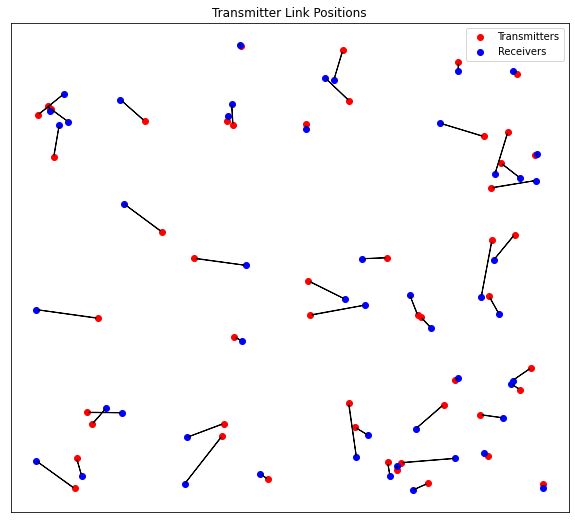

In [20]:
Tx = np.asarray([layouts[0][i][:2] for i in range (0,parameters().n_links)]).T
Rx = np.asarray([layouts[0][i][2:] for i in range (0,parameters().n_links)]).T

fig, ax1  = plt.subplots(1,figsize=(10,10))
fig.autofmt_xdate()

ax1.scatter( Tx[0], Tx[1], color="red", label="Transmitters")
ax1.scatter( Rx[0], Rx[1], color="Blue", label="Receivers")

for i in range(0, parameters().n_links):
    ar = mpatches.FancyArrowPatch((Tx[0][i],Tx[1][i]),(Rx[0][i],Rx[1][i]), arrowstyle='fancy')
    ax1.add_patch(ar)

    
    
ax1.set_title('Transmitter Link Positions')
ax1.legend(loc='best');
plt.xticks([])
plt.yticks([])
plt.show()

In [13]:
test_path_losses = compute_path_losses(parameters(), dists)

if(parameters().INCLUDE_FADING):
    print("Testing under CSI including fading realizations...")
    test_channel_losses = add_shadowing(test_path_losses)
    test_channel_losses = add_fast_fading(test_channel_losses)
else:
    print("Testing under CSI consists of path losses only...")
    channel_losses = path_losses

test_directLink_channel_losses = get_directLink_channel_losses(test_channel_losses)
test_crossLink_channel_losses = get_crossLink_channel_losses(test_channel_losses)

allocs_all_methods = {}
sum_rates_all_methods = {}
allocs_all_methods["All Active"] = np.ones([parameters().n_layouts, parameters().n_links]).astype(float)
allocs_all_methods["FP"] = FP(parameters(), test_channel_losses, np.ones([parameters().n_layouts, parameters().n_links]))
allocs_all_methods["FP Not Knowing Fading"] = FP(parameters(), test_path_losses, np.ones([parameters().n_layouts, parameters().n_links]))
allocs_all_methods["Greedy"] = Greedy_Scheduling(parameters(), test_directLink_channel_losses, test_crossLink_channel_losses, np.ones([parameters().n_layouts, parameters().n_links]))
allocs_all_methods["Strongest Link Only"] = Strongest_Link_Scheduling(parameters(), test_directLink_channel_losses)
allocs_all_methods["Random"] = np.random.randint(2, size=[parameters().n_layouts, parameters().n_links]).astype(float)

for method_key in allocs_all_methods.keys():
    all_links_rates = compute_rates(parameters(), allocs_all_methods[method_key], test_directLink_channel_losses, test_crossLink_channel_losses) # n_layouts X N
    sum_rates = np.sum(all_links_rates,axis=-1)
    sum_rates_all_methods[method_key] = sum_rates
print("[Sum-Rate Performance Ratios Averaged over all Layouts]")
assert "FP" in allocs_all_methods.keys(), "[evaluate.py] Didn't include FP in sum-rate computation"
for method_key in allocs_all_methods.keys():
    if(method_key == "FP"):
        continue
    ratios = sum_rates_all_methods[method_key]/sum_rates_all_methods["FP"]*100
    print("[{}]: avg {}% of FP;".format(method_key, round(np.mean(ratios),2)), end="\n")
print("\n")

Testing under CSI including fading realizations...
[Sum-Rate Performance Ratios Averaged over all Layouts]
[All Active]: avg 43.21% of FP;
[FP Not Knowing Fading]: avg 70.48% of FP;
[Greedy]: avg 97.95% of FP;
[Strongest Link Only]: avg 38.67% of FP;
[Random]: avg 38.24% of FP;




In [12]:
class eps_agent_bandit:
    '''
    epsilon-greedy k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, eps, iters):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = [0,0]
              
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        return a
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def update(self, a, reward):
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

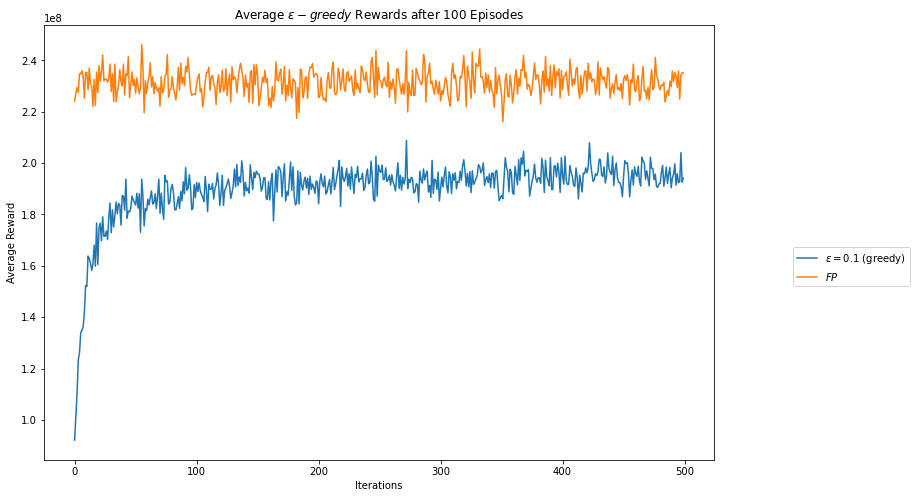

In [14]:
#vanilla Multi-Agent MAB
k = 2
iters = 500

allocations = [[None] * parameters().n_links] * iters
allocations_FP = [None] * iters
allocations_FP_nofading = [None] * iters
agents = [None] * parameters().n_links
rewards_RL = np.zeros(iters)  
rewards_FP = np.zeros(iters)
rewards_FP_nofading = np.zeros(iters)
episodes = 100



# Run experiments
#for layout in range(parameters().n_layouts):
for i in range(episodes):
    # Initialize bandits
    for j in range (parameters().n_links):
        agents[j] = eps_agent_bandit(k, 0.1, iters)

    for t in range(iters):
        for j in range (parameters().n_links):
            allocations[t][j] = agents[j].pull()


        path_losses = compute_path_losses(parameters(), dists[0])
        if(parameters().INCLUDE_FADING):
            channel_losses = add_shadowing(path_losses)
            channel_losses = add_fast_fading(channel_losses)
        else:
            channel_losses = path_losses
        
    
        directLink_channel_losses = get_directLink_channel_losses_single(channel_losses)
        crossLink_channel_losses = get_crossLink_channel_losses(channel_losses)
        agent_rates = compute_rates_single(parameters(), allocations[t], directLink_channel_losses, crossLink_channel_losses) # N
        agent_rates_FP = compute_rates_single(parameters(), allocs_all_methods['FP'][0], directLink_channel_losses, crossLink_channel_losses) # N
        reward_FP = np.sum(agent_rates_FP)
        agent_rates_FP_nofading = compute_rates_single(parameters(), allocs_all_methods['FP Not Knowing Fading'][0], directLink_channel_losses, crossLink_channel_losses) # N
        reward_FP_nofading = np.sum(agent_rates_FP_nofading)
        reward = np.sum(agent_rates)

        rewards_RL[t] = rewards_RL[t] + (reward - rewards_RL[t]) / (i + 1)
        rewards_FP[t] = rewards_FP[t] + (reward_FP - rewards_FP[t]) / (i + 1)
        rewards_FP_nofading[t] = rewards_FP_nofading[t] + (reward_FP_nofading - rewards_FP_nofading[t]) / (i + 1)

        for j in range (parameters().n_links):
            agents[j].update(allocations[t][j], reward)
#for j in range(parameters().n_links):
#   agents[j].reset()
    
plt.figure(figsize=(12,8))
plt.plot(rewards_RL, label="$\epsilon=0.1$ (greedy)")
plt.plot(rewards_FP, label="$FP$")
plt.plot(rewards_FP_nofading, label="$FP No Fading$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")

plt.show()


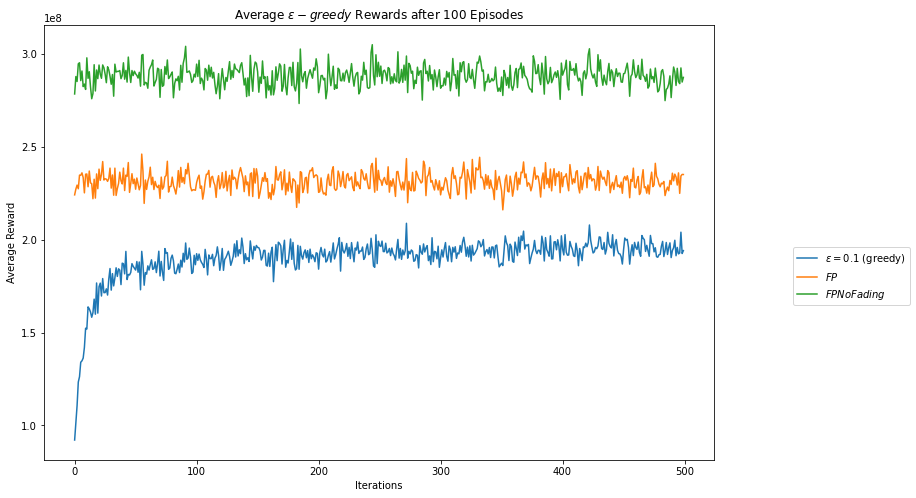

In [15]:
plt.figure(figsize=(12,8))
plt.plot(rewards_RL, label="$\epsilon=0.1$ (greedy)")
plt.plot(rewards_FP, label="$FP$")
plt.plot(rewards_FP_nofading, label="$FP No Fading$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")

plt.show()

In [86]:
class eps_DRL_agent_bandit:
    '''
    epsilon-greedy k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, eps, iters, agent_n):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = [0,0]
        self.agent_n = agent_n
        self.preds = [0,0]
        self.mse = np.zeros(iters)
        self.random_period = 50
        
        
        self.model = Sequential()

        #self.model.add(Dense(20, input_dim = parameters().n_links, activation='relu', kernel_regularizer='l2'))
        self.model.add(Dense(200, input_dim = parameters().n_links, activation='relu'))
        self.model.add(Dense(200, activation='relu'))
        self.model.add(Dense(100, activation='relu'))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        opt = Adam(learning_rate=0.001)
        self.model.compile(loss='mae', optimizer=opt)
        #print(self.model.summary())
              
    def pull(self, prev_actions = np.zeros(parameters().n_links)):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps or self.n<self.random_period:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            input_0 = prev_actions[:]
            input_1 = prev_actions[:]
            input_0[self.agent_n] = 0
            input_1[self.agent_n] = 1
            
            self.preds[0] = self.model.predict(np.asarray([input_0]))
            self.preds[1] = self.model.predict(np.asarray([input_1]))
            
            if self.preds[0] == self.preds[1]:
                a = np.random.choice(self.k)
            else:
                a = np.argmax(self.preds)

        # Update counts
        self.n += 1
        self.k_n[a] += 1
        return a
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def update(self, a, reward):
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a[self.agent_n]] = self.k_reward[a[self.agent_n]] + (
            reward - self.k_reward[a[self.agent_n]]) / self.k_n[a[self.agent_n]]
        
        self.model.fit(np.asarray([a]), np.asarray([reward]), batch_size = 1, epochs = 10, verbose = 0)
        self.mse[self.n -1] = self.model.evaluate(np.asarray([a]), np.asarray([reward]), verbose = 0)
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

In [87]:
#DRL Multi-Agent
k = 2
iters = 200
layout_n = 1

allocations = [[0] * parameters().n_links] * iters
#allocations_FP = [None] * iters
#allocations_FP_nofading = [None] * iters
agents = [None] * parameters().n_links
rewards = np.zeros(iters)  
rewards_FP = np.zeros(iters)
rewards_FP_nofading = np.zeros(iters)
episodes = 1
allocation = []
allocations_DRL = [None] * layout_n 
#layout_n = parameters().n_layouts


# Run experiments
for layout in range(layout_n):
    print("layout ", layout)
    for i in range(episodes):
        print("Episode ",i, "\n")
        # Initialize bandits
        for j in range (parameters().n_links):
            agents[j] = eps_DRL_agent_bandit(k, 0.1, iters, j)

        for t in range(iters):
            #print('Iteration = ', t)
            allocation = [][:]
            for j in range (parameters().n_links):
                if t>0:
                    allocation.append(agents[j].pull(allocations[t-1]))
                    #allocations[t][j] = agents[j].pull(allocations[t-1])
                    allocations[t] = allocation[:]
                    #print(allocations[t][j])
                else: 
                    allocation.append(agents[j].pull())
                    allocations[t] = allocation[:]
                    #allocations[t][j] = agents[j].pull()
            #print(allocations[t] == allocations[t-1]
            path_losses = compute_path_losses(parameters(), dists[2])
            if(parameters().INCLUDE_FADING):
                channel_losses = add_shadowing(path_losses)
                channel_losses = add_fast_fading(channel_losses)
            else:
                channel_losses = path_losses

            #allocations_FP[t] = FP(parameters(), [channel_losses], np.ones([1, parameters().n_links]))
            #allocations_FP_nofading[t] = FP(parameters(), [path_losses], np.ones([1, parameters().n_links]))
            directLink_channel_losses = get_directLink_channel_losses_single(channel_losses)
            crossLink_channel_losses = get_crossLink_channel_losses(channel_losses)
            agent_rates = compute_rates_single(parameters(), allocations[t], directLink_channel_losses, crossLink_channel_losses) # N
            reward = np.sum(agent_rates)
            agent_rates_FP = compute_rates_single(parameters(), allocs_all_methods['FP'][2], directLink_channel_losses, crossLink_channel_losses) # N
            reward_FP = np.sum(agent_rates_FP)
            agent_rates_FP_nofading = compute_rates_single(parameters(), allocs_all_methods['FP Not Knowing Fading'][2], directLink_channel_losses, crossLink_channel_losses) # N
            reward_FP_nofading = np.sum(agent_rates_FP_nofading)


            rewards[t] = rewards[t] + (reward - rewards[t]) / (i + 1)
            rewards_FP[t] = rewards_FP[t] + (reward_FP - rewards_FP[t]) / (i + 1)
            rewards_FP_nofading[t] = rewards_FP_nofading[t] + (reward_FP_nofading - rewards_FP_nofading[t]) / (i + 1)


            for j in range (parameters().n_links):
                agents[j].update(allocations[t], reward)
        allocations_DRL[layout] = allocations[t][:]

    



layout  0
Episode  0 



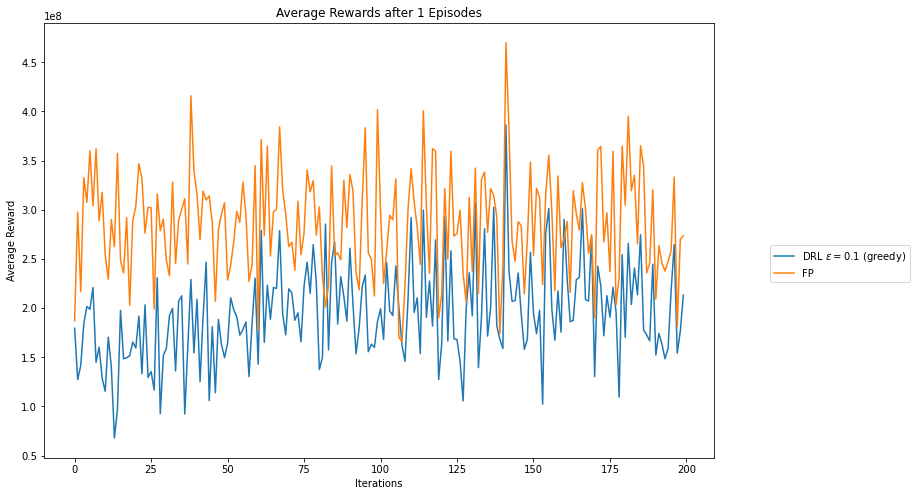

In [88]:
plt.figure(figsize=(12,8))
plt.plot(rewards, label="DRL $\epsilon=0.1$ (greedy)")
plt.plot(rewards_FP, label="FP")
#plt.plot(rewards_FP_nofading, label="FP No Fading")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Rewards after " + str(episodes) 
    + " Episodes")

plt.show()

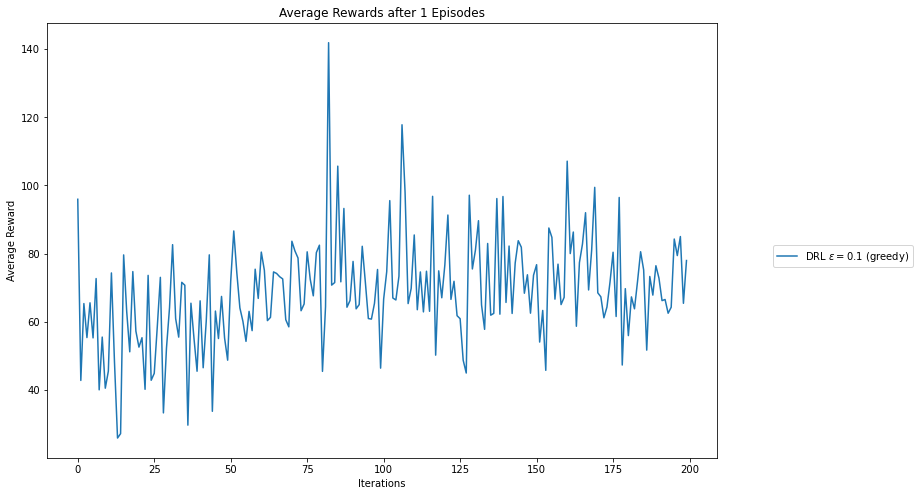

In [89]:
plt.figure(figsize=(12,8))
plt.plot(rewards/rewards_FP*100, label="DRL $\epsilon=0.1$ (greedy)")
#plt.plot(rewards_FP_nofading, label="FP, label No Fading")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Rewards after " + str(episodes) 
    + " Episodes")

plt.show()

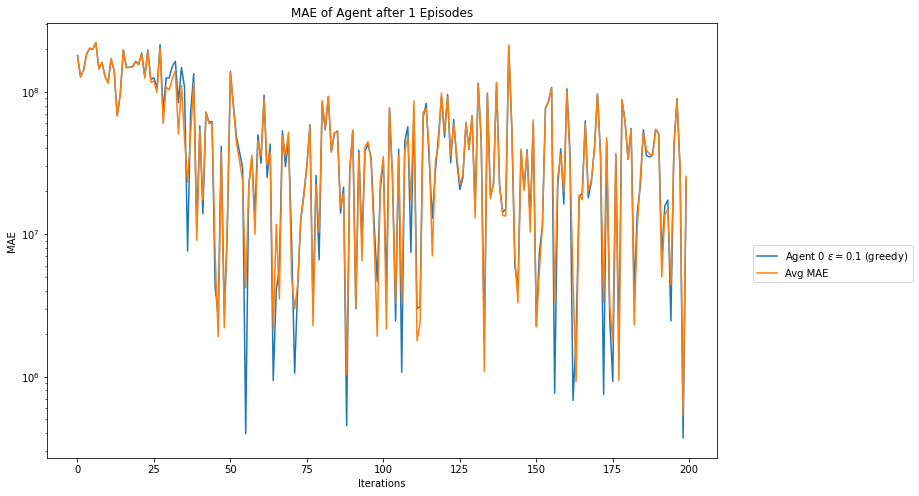

In [90]:
avg_mse = np.zeros(iters)
for i in range(parameters().n_links):
    avg_mse += agents[i].mse /parameters().n_links


plt.figure(figsize=(12,8))
plt.plot(agents[0].mse, label="Agent 0 $\epsilon=0.1$ (greedy)")
plt.plot(avg_mse, label="Avg MAE")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("MAE")
plt.title("MAE of Agent after " + str(episodes) 
    + " Episodes")
plt.yscale("log")
plt.show()

In [32]:
alloc_rates_avg = [0] * iters
alloc_rates_ratio = [0] * iters
path_losses = compute_path_losses(parameters(), np.array(dists[:30]))
placeholder_allocs = [[0] * parameters().n_links] * 30 

modified_DRL_avg_alloc = 0
FP_rates_forallocs_avg = 0
for i in range(iters):
    for j in range(100):
        if(parameters().INCLUDE_FADING):
            #print("Testing under CSI including fading realizations... \n")
            channel_losses = add_shadowing(path_losses)
            channel_losses = add_fast_fading(channel_losses)
        else:
            # print("Testing under CSI consists of path losses only... \n")
            channel_losses = path_losses[:]
        
        directLink_channel_losses = get_directLink_channel_losses(channel_losses)
        crossLink_channel_losses = get_crossLink_channel_losses(channel_losses)
        
        placeholder_allocs[0] = allocations[i][:]
        alloc_rates = compute_rates(parameters(), placeholder_allocs, directLink_channel_losses, crossLink_channel_losses) 
        alloc_rates_sum = np.sum( alloc_rates, axis=-1 )
        modified_DRL_avg_alloc = modified_DRL_avg_alloc + (alloc_rates_sum - modified_DRL_avg_alloc)/(j+1)
        FP_rates_forallocs = compute_rates(parameters(), allocs_all_methods['FP'][:30], directLink_channel_losses, crossLink_channel_losses) 
        FP_rates_forallocs_sum = np.sum(FP_rates_forallocs, axis = -1)
        FP_rates_forallocs_avg = FP_rates_forallocs_avg + (FP_rates_forallocs_sum - FP_rates_forallocs_avg)/(j+1)
        ratios_allocs = modified_DRL_avg_alloc/FP_rates_forallocs_avg *100
    alloc_rates_avg[i] = modified_DRL_avg_alloc[0]
    alloc_rates_ratio[i] = ratios_allocs[0]

#print(alloc_rates_avg)

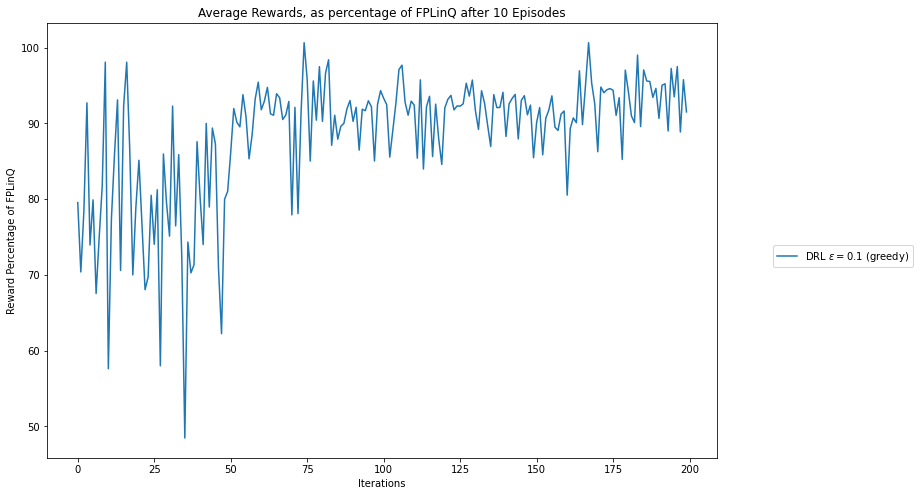

In [33]:
plt.figure(figsize=(12,8))
plt.plot(alloc_rates_ratio, label="DRL $\epsilon=0.1$ (greedy)")
#plt.plot(rewards_FP, label="FP")
#plt.plot(rewards_FP_nofading, label="FP No Fading")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Reward Percentage of FPLinQ")
plt.title("Average Rewards, as percentage of FPLinQ after " + str(episodes) 
    + " Episodes")

plt.show()

In [143]:
#path_losses = compute_path_losses(parameters(), dists[:30])
FP_avg = 0
FP_avg_nofade = 0
DRL_avg = 0
#for i in range(100):
#    if(parameters().INCLUDE_FADING):
#        #print("Testing under CSI including fading realizations... \n")
#        channel_losses = add_shadowing(path_losses)
#        channel_losses = add_fast_fading(channel_losses)
#    else:
#       # print("Testing under CSI consists of path losses only... \n")
#        channel_losses = path_losses

#   directLink_channel_losses = get_directLink_channel_losses(channel_losses)
#    crossLink_channel_losses = get_crossLink_channel_losses(channel_losses)
    
FP_rates = compute_rates(parameters(), allocs_all_methods['FP'][:50], test_directLink_channel_losses[:50], test_crossLink_channel_losses[:50]) # n_layouts X N
FP_rates_sum = np.sum(FP_rates,axis=-1)
FP_avg = FP_avg + (FP_rates_sum - FP_avg)/(i+1)
    
#     FP_allocs_nofade = FP(parameters(), path_losses, np.ones([30, parameters().n_links]))
#    FP_rates_nofade = compute_rates(parameters(), allocs_all_methods['FP Not Knowing Fading'][:30], directLink_channel_losses, crossLink_channel_losses) # n_layouts X N
#    FP_rates_sum_nofade = np.sum(FP_rates_nofade,axis=-1)
    
#    FP_avg_nofade = FP_avg_nofade + (FP_rates_sum_nofade - FP_avg_nofade)/(i+1)
    
DRL_rates = compute_rates(parameters(), allocations_DRL, test_directLink_channel_losses[:50], test_crossLink_channel_losses[:50]) # n_layouts X N
DRL_rates_sum = np.sum(DRL_rates,axis=-1)

DRL_avg = DRL_avg + (DRL_rates_sum - DRL_avg)/(i+1)

#ratios = DRL_avg/FP_avg*100
#ratios = FP_avg_nofade/FP_avg*100
#print(ratios, "\n")
#print("[FP No Fading]: avg {}% of FP;".format( round(np.mean(ratios),2)), end="\n")

ratios = DRL_avg/FP_avg*100
print("[DRL]: avg {}% of FP;".format( round(np.mean(ratios),2)), end="\n")

[DRL]: avg 46.12% of FP;


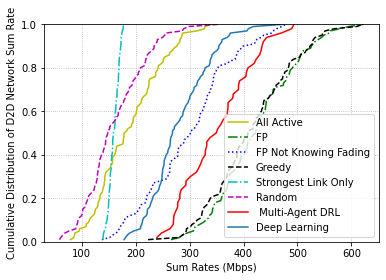

In [151]:
# Plot CDF curve
line_styles = dict()
line_styles["Deep Learning"] = "-"
line_styles["FP"] = "g-."
line_styles["FP Not Knowing Fading"] = "b:" # most time not used
line_styles["Greedy"] = "k--"
line_styles["Strongest Link Only"] = "c-."
line_styles["All Active"] = "y-"
line_styles["Random"] = "m--"
line_styles["DRL"] = "r-"
fig = plt.figure()
ax = fig.gca()
plt.xlabel("Sum Rates (Mbps)")
plt.ylabel("Cumulative Distribution of D2D Network Sum Rate")
plt.grid(linestyle="dotted")
ax.set_ylim(bottom=0)
for method_key in allocs_all_methods.keys():
    sum_rates = np.sort(sum_rates_all_methods[method_key])
    plt.plot(sum_rates/1e6, np.arang200e(1, parameters().n_layouts+1) / parameters().n_layouts, line_styles[method_key], label=method_key)
    plt.legend()
    

#temp = np.zeros(parameters().n_layouts) 
#temp[:10] += 
DRL_rates_sum_sorted = np.sort(DRL_rates_sum)
plt.plot(DRL_rates_sum_sorted/1e6, np.arange(1, parameters().n_layouts+1) / parameters().n_layouts, line_styles["DRL"], label=" Multi-Agent DRL")
plt.legend()
plt.show()

In [27]:
def modify_layouts( layouts, max_axis_jump ):     
    modified_layouts = copy.deepcopy(layouts)
    modified_dists = []
    for layout_n in range(len(modified_layouts)):
        for link_n in range(parameters().n_links):
            coords = modified_layouts[layout_n][link_n][:]
            for i in range(len(coords)):
                jump = np.random.uniform(-max_axis_jump, max_axis_jump)
                if(coords[i] + jump < parameters().field_length and coords[i] + jump > 0):
                    coords[i] += jump
            modified_layouts[layout_n][link_n] = coords[:]
        
        layout_dists = np.zeros([parameters().n_links, parameters().n_links])
        
        for rx_index in range(parameters().n_links):
            for tx_index in range(parameters().n_links):
                tx_coor = modified_layouts[layout_n][tx_index][0:2]
                rx_coor = modified_layouts[layout_n][rx_index][2:4]
                # according to paper notation convention, Hij is from jth transmitter to ith receiver
                layout_dists[rx_index][tx_index] = np.linalg.norm(tx_coor - rx_coor)
        modified_dists.append(layout_dists)    
    
    return modified_layouts, modified_dists



In [37]:
modified_layouts, modified_dists = modify_layouts( layouts[:10], 100 )

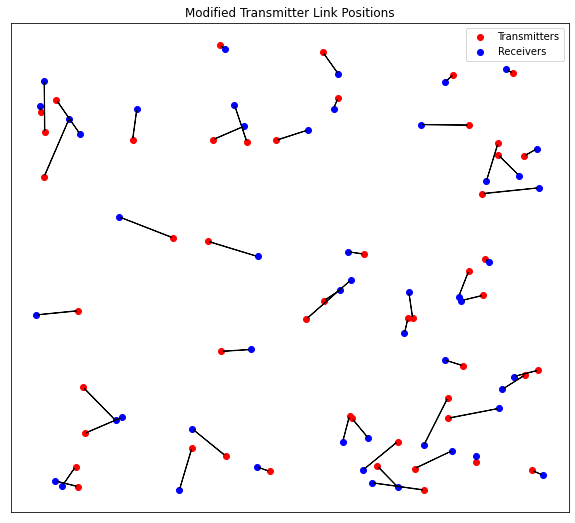

In [48]:
Tx = np.asarray([modified_layouts[0][i][:2] for i in range (0,parameters().n_links)]).T
Rx = np.asarray([modified_layouts[0][i][2:] for i in range (0,parameters().n_links)]).T

fig, ax1  = plt.subplots(1,figsize=(10,10))
fig.autofmt_xdate()

ax1.scatter( Tx[0], Tx[1], color="red", label="Transmitters")
ax1.scatter( Rx[0], Rx[1], color="Blue", label="Receivers")

for i in range(0, parameters().n_links):
    ar = mpatches.FancyArrowPatch((Tx[0][i],Tx[1][i]),(Rx[0][i],Rx[1][i]), arrowstyle='fancy')
    ax1.add_patch(ar)

    
    
ax1.set_title('Modified Transmitter Link Positions')
ax1.legend(loc='best');
plt.xticks([])
plt.yticks([])
plt.show()

In [40]:
modified_agents = copy.deepcopy(agents)
for j in range(parameters().n_links):
    modified_agents[j].n = 0
    modified_agents[j].random_period = 0

In [41]:
#DRL Multi-Agent modified locations
k = 2
iters = 200
layout_n = 1

modified_allocations = [[None] * parameters().n_links] * iters
rewards_FP = np.zeros(iters)
#modified_agents = copy.deepcopy(agents)
modified_rewards = np.zeros(iters)  
allocation =[][:]
episodes = 1
modified_allocations_DRL = [[0] * parameters().n_links] * layout_n 
#layout_n = parameters().n_layouts
modified_layouts = copy.deepcopy(layouts)


# Run experiments
#for layout in range(layout_n):
    #print("layout ", layout)
for i in range(episodes):


    for t in range(iters):
        modified_layouts, modified_dists = modify_layouts( modified_layouts, 1 )
        allocation =[][:]
        #print('Iteration = ', t)
        for j in range (parameters().n_links):
            if t>0:
                allocation.append(agents[j].pull(modified_allocations[t-1]))
                modified_allocations[t] = allocation[:]
            else: 
                allocation.append(agents[j].pull())
                modified_allocations[t] = allocation[:]
        path_losses = compute_path_losses(parameters(), modified_dists[0])
        if(parameters().INCLUDE_FADING):
            channel_losses = add_shadowing(path_losses)
            channel_losses = add_fast_fading(channel_losses)
        else:
            channel_losses = path_losses[:]

        #allocations_FP[t] = FP(parameters(), [channel_losses], np.ones([1, parameters().n_links]))
        #allocations_FP_nofading[t] = FP(parameters(), [path_losses], np.ones([1, parameters().n_links]))
        directLink_channel_losses = get_directLink_channel_losses_single(channel_losses)
        crossLink_channel_losses = get_crossLink_channel_losses(channel_losses)
        agent_rates = compute_rates_single(parameters(), modified_allocations[t], directLink_channel_losses, crossLink_channel_losses) # N
        reward = np.sum(agent_rates)
        agent_rates_FP = compute_rates_single(parameters(), allocs_all_methods['FP'][0], directLink_channel_losses, crossLink_channel_losses) # N
        reward_FP = np.sum(agent_rates_FP)

        modified_rewards[t] = modified_rewards[t] + (reward - modified_rewards[t]) / (i + 1)
        rewards_FP[t] = rewards_FP[t] + (reward_FP - rewards_FP[t]) / (i + 1)
        #rewards_FP_nofading[t] = rewards_FP_nofading[t] + (reward_FP_nofading - rewards_FP_nofading[t]) / (i + 1)


        for j in range (parameters().n_links):
            modified_agents[j].update(modified_allocations[t], reward)
   # modified_allocations_DRL[1] = modified_allocations[t]

    



C:\Users\briro\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\briro\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars


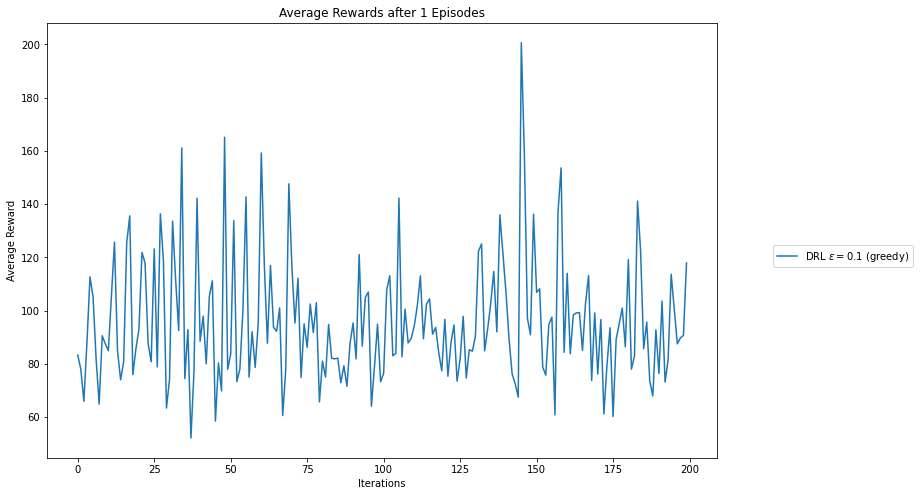

In [42]:
plt.figure(figsize=(12,8))
plt.plot(modified_rewards/rewards_FP*100, label="DRL $\epsilon=0.1$ (greedy)")
#plt.plot(rewards_FP_nofading, label="FP, label No Fading")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Rewards after " + str(episodes) 
    + " Episodes")

plt.show()

In [553]:
path_losses = compute_path_losses(parameters(), np.array(modified_dists[:30]))
modified_FP_avg = 0
modified_FP_avg_nofade = 0
modified_DRL_avg = 0
#modified_DRL_avg_indiv = [0] * iters
for i in range(100):
    if(parameters().INCLUDE_FADING):
        #print("Testing under CSI including fading realizations... \n")
        channel_losses = add_shadowing(path_losses)
        channel_losses = add_fast_fading(channel_losses)
    else:
       # print("Testing under CSI consists of path losses only... \n")
        channel_losses = path_losses

    directLink_channel_losses = get_directLink_channel_losses(channel_losses)
    crossLink_channel_losses = get_crossLink_channel_losses(channel_losses)
    
    modified_FP_rates = compute_rates(parameters(), allocs_all_methods['FP'][:30], directLink_channel_losses, crossLink_channel_losses) # n_layouts X N
    modified_FP_rates_sum = np.sum(modified_FP_rates,axis=-1)
    modified_FP_avg = modified_FP_avg + (modified_FP_rates_sum - modified_FP_avg)/(i+1)
    
    #FP_allocs_nofade = FP(parameters(), path_losses, np.ones([30, parameters().n_links]))
    #FP_rates_nofade = compute_rates(parameters(), allocs_all_methods['FP Not Knowing Fading'][29], directLink_channel_losses, crossLink_channel_losses) # n_layouts X N
    #FP_rates_sum_nofade = np.sum(FP_rates_nofade,axis=-1)
    
    #FP_avg_nofade = FP_avg_nofade + (FP_rates_sum_nofade - FP_avg_nofade)/(i+1)
    
    modified_DRL_rates = compute_rates(parameters(), modified_allocations_DRL[:30], directLink_channel_losses, crossLink_channel_losses) # n_layouts X N
    modified_DRL_rates_sum = np.sum(modified_DRL_rates,axis=-1)
    
    modified_DRL_avg = modified_DRL_avg + (modified_DRL_rates_sum - modified_DRL_avg)/(i+1)

#ratios = DRL_avg/FP_avg*100
#ratios = FP_avg_nofade/FP_avg*100
#print(ratios, "\n")
#print("[FP No Fading]: avg {}% of FP;".format( round(np.mean(ratios),2)), end="\n")

modified_ratios = modified_DRL_avg/modified_FP_avg*100
print("[DRL]: avg {}% of FP;".format( round(modified_ratios[29]), end="\n"))

[DRL]: avg 60.0% of FP;


In [564]:
np.shape(directLink_channel_losses)

(50,)

In [229]:
modified_allocations_DRL = [[0] * parameters().n_links] * 30 
modified_allocations_DRL[29] = modified_allocations[1]

In [230]:
alloc_rates_avg = [0] * iters
alloc_rates_ratio = [0] * iters
path_losses = compute_path_losses(parameters(), np.array(modified_dists[:30]))
placeholder_allocs = [[0] * parameters().n_links] * 30 

modified_DRL_avg_alloc = 0
for i in range(iters):
    for j in range(100):
        if(parameters().INCLUDE_FADING):
            #print("Testing under CSI including fading realizations... \n")
            channel_losses = add_shadowing(path_losses)
            channel_losses = add_fast_fading(channel_losses)
        else:
            # print("Testing under CSI consists of path losses only... \n")
            channel_losses = path_losses
        
        directLink_channel_losses = get_directLink_channel_losses(channel_losses)
        crossLink_channel_losses = get_crossLink_channel_losses(channel_losses)
        
        placeholder_allocs[29] = modified_allocations[i]
        alloc_rates = compute_rates(parameters(), placeholder_allocs, directLink_channel_losses, crossLink_channel_losses) 
        alloc_rates_sum = np.sum( alloc_rates, axis=-1 )
        modifievd_DRL_avg_alloc = modified_DRL_avg_alloc + (alloc_rates_sum - modified_DRL_avg_alloc)/(j+1)
        
        modified_DRL_avg_alloc = modified_DRL_avg_alloc + (alloc_rates_sum - modified_DRL_avg_alloc)/(j+1)
        FP_rates_forallocs = compute_rates(parameters(), allocs_all_methods['FP'][:30], directLink_channel_losses, crossLink_channel_losses) 
        FP_rates_forallocs_sum = np.sum(FP_rates_forallocs, axis = -1)
        FP_rates_forallocs_avg = FP_rates_forallocs_avg + (FP_rates_forallocs_sum - FP_rates_forallocs_avg)/(j+1)
        ratios_allocs = modified_DRL_avg_alloc/FP_rates_forallocs_avg *100
    alloc_rates_avg[i] = modified_DRL_avg_alloc[29]
    alloc_rates_ratio[i] = ratios_allocs[29]


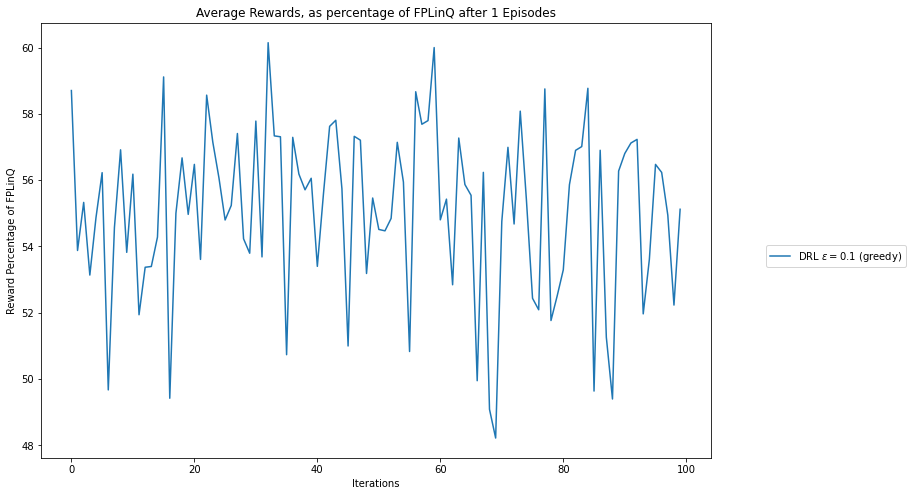

In [231]:
plt.figure(figsize=(12,8))
plt.plot(alloc_rates_ratio, label="DRL $\epsilon=0.1$ (greedy)")
#plt.plot(rewards_FP, label="FP")
#plt.plot(rewards_FP_nofading, label="FP No Fading")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Reward Percentage of FPLinQ")
plt.title("Average Rewards, as percentage of FPLinQ after " + str(episodes) 
    + " Episodes")

plt.show()

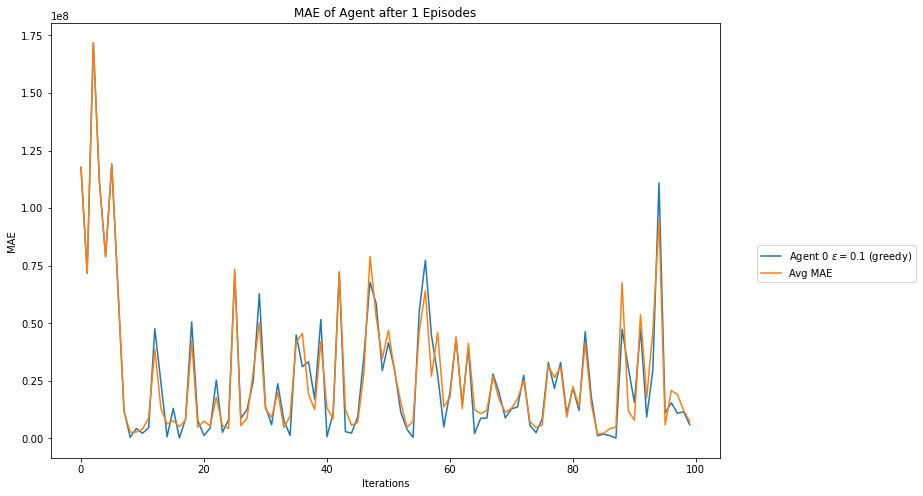

In [232]:
avg_mse = np.zeros(iters)
for i in range(parameters().n_links):
    avg_mse += modified_agents[i].mse[0:100] /parameters().n_links

plt.figure(figsize=(12,8))
plt.plot(modified_agents[0].mse[0:100], label="Agent 0 $\epsilon=0.1$ (greedy)")
plt.plot(avg_mse, label="Avg MAE")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("MAE")
plt.title("MAE of Agent after " + str(episodes) 
    + " Episodes")
#plt.yscale("log")
plt.show()